In [ ]:
# Descarga del modelo de caja negra, los labels y la clase BlackBoxCNN

!gdown https://drive.google.com/uc?id=1bv6uXZVnGTWKp8OFG9Vl_BpW9cnLbVzQ
!gdown https://drive.google.com/uc?id=1MU-ILaGaIKRR1RLEw9oX7oaJl_fcwa01
!gdown https://drive.google.com/uc?id=1lKuIgGQx86beN4hzkM0fFkf5FPe6rq1y

Downloading...
From: https://drive.google.com/uc?id=1bv6uXZVnGTWKp8OFG9Vl_BpW9cnLbVzQ
To: /content/classes.txt
100% 10.5k/10.5k [00:00<00:00, 21.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MU-ILaGaIKRR1RLEw9oX7oaJl_fcwa01
To: /content/BlackBoxCNN
100% 103M/103M [00:02<00:00, 38.0MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1lKuIgGQx86beN4hzkM0fFkf5FPe6rq1y
To: /content/blackboxcnn.py
100% 1.99k/1.99k [00:00<00:00, 5.92MB/s]


In [ ]:
categories_path = "/content/classes.txt"
blackbox_path = "/content/BlackBoxCNN"

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, Subset, Sampler
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision import datasets
from PIL import Image

import os
from tqdm import tqdm

from blackboxcnn import BlackBoxCNN

In [ ]:
# Sampler para seleccionar clases en particular
class ClassIDSampler(Sampler):
    def __init__(self, dataset_labels, class_id):
      self.mask = torch.tensor([idx in class_id for idx in dataset_labels])

    def __iter__(self):
      masked_indices = torch.nonzero(self.mask)
      masked_indices = masked_indices[torch.randperm(masked_indices.shape[0])]
      return (idx for idx in masked_indices)

    def __len__(self):
      return len(self.mask)

## Carga de datos

### Preprocesamiento

In [ ]:
# Pre-procesamiento requerido por la caja negra
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Entrenando la caja negra

###Descargando la base de datos

In [ ]:
Dataset = datasets.Caltech101('/content/101_ObjectCategories', download=True, transform= transforms.ToTensor())

import numpy as np
import math
from typing import List
import os
import argparse
import glob
import shutil

def list_files(path):
    files = os.listdir(path)
    return np.asarray(files)

def split_files(oldpath, newpath, classes):
    for name in classes:
        full_dir = os.path.join(os.getcwd(), f"{oldpath}/{name}")

        files = list_files(full_dir)
        total_file = np.size(files,0)
        # We split data set into 3: train, validation and test

        train_size = math.ceil(total_file * 3/4) # 75% for training 

        validation_size = train_size + math.ceil(total_file * 1/8) # 12.5% for validation
        test_size = validation_size + math.ceil(total_file * 1/8) # 12.5x% for testing 

        train = files[0:train_size]
        validation = files[train_size:validation_size]
        test = files[validation_size:]

        move_files(train, full_dir, f"train/{name}")
        move_files(validation, full_dir, f"validation/{name}")
        move_files(test, full_dir, f"test/{name}")

def move_files(files, old_dir, new_dir):
    new_dir = os.path.join(os.getcwd(), new_dir);
    if not os.path.exists(new_dir):
        os.makedirs(new_dir)

    for file in np.nditer(files):
        old_file_path = os.path.join(os.getcwd(), f"{old_dir}/{file}")
        new_file_path = os.path.join(os.getcwd(), f"{new_dir}/{file}")

        shutil.move(old_file_path, new_file_path)


      
classes = list(Dataset.categories)
print(len(classes))
split_files('101_ObjectCategories/caltech101/101_ObjectCategories', './', classes)

0it [00:00, ?it/s]

Extracting /content/101_ObjectCategories/caltech101/101_ObjectCategories.tar.gz to /content/101_ObjectCategories/caltech101


0it [00:00, ?it/s]

Extracting /content/101_ObjectCategories/caltech101/101_Annotations.tar to /content/101_ObjectCategories/caltech101
101


In [ ]:
data = {
    'train': datasets.ImageFolder(root='./train', transform= preprocess),
    'validation': datasets.ImageFolder(root='./validation', transform= preprocess),
    'test': datasets.ImageFolder(root='./test', transform= preprocess)
}
batch_size = 32
train_data = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
validation_data = DataLoader(data['validation'], batch_size=batch_size, shuffle=True)
test_data = DataLoader(data['test'], batch_size=batch_size, shuffle=True)

## Entrenado

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class MyNetBig(nn.Module):
 def __init__(self, nclasses):
  super(MyNetBig, self).__init__()
  self.nclasses = nclasses
  self.conv1 = nn.Conv2d(3, 64, 3, padding = 1)
  self.bn1 = nn.BatchNorm2d(64)

  self.conv2 = nn.Conv2d(64, 64, 3, padding = 1)
  self.bn2 = nn.BatchNorm2d(64) 

  self.pol1 = nn.MaxPool2d(2,stride=2)

  self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
  self.bn3 = nn.BatchNorm2d(128)

  self.conv4 = nn.Conv2d(128, 128, 3, padding = 1)
  self.bn4 = nn.BatchNorm2d(128) 

  self.pol2 = nn.MaxPool2d(2,stride=2)

  self.fc1 = nn.Linear(100352,128)
  self.bn9 = nn.BatchNorm1d(128)

  self.fc2 = nn.Linear(128,256)
  self.bn10 = nn.BatchNorm1d(256)

  self.fc3 = nn.Linear(256,512)
  self.bn11 = nn.BatchNorm1d(512)

  self.fc4 = nn.Linear(512,1024)
  self.bn12 = nn.BatchNorm1d(1024)

  self.fc5 = nn.Linear(1024,self.nclasses)

 def forward(self, x):
  x = self.bn1(F.relu(self.conv1(x)))
  x = self.bn2(F.relu(self.conv2(x)))  
  x = F.max_pool2d(x, 2, stride=2)
  x = self.bn3(F.relu(self.conv3(x))) 
  x = self.bn4(F.relu(self.conv4(x)))   
  x = F.max_pool2d(x, 2, stride=2)    
  x = F.max_pool2d(x, 2, stride=2)
  
  x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))  # Operación para realizar un flatten de 
                                      # para los datos
  x = self.bn9(F.relu(self.fc1(x)))
  x = self.bn10(F.relu(self.fc2(x)))
  x = self.bn11(F.relu(self.fc3(x)))
  x = self.bn12(F.relu(self.fc4(x)))     
  x = self.fc5(x)
  return x

## Cargando los modelos

In [ ]:
# Variable que indica si es que se seguirá entrenando una red que ya fue 
# entrenada. 
pretrained = True

# Variable para decidir si se quiere entrenar, para sólo ver resultados, dejar 
# en False
train = False

if pretrained:
  !gdown https://drive.google.com/u/0/uc?id=1GslmiouiIwjMw00nF7WokZ3SDiZu_Xpw&export=download
  net = torch.load('net-resnet-v6')
else:
  net = MyNetBig(1000)

blackbox = torch.load('/content/BlackBoxCNN')

In [ ]:
if train:
  net.cuda()  # Consideración para utilizar la GPU
  blackbox.cuda()
  criterion = nn.CrossEntropyLoss() # Función de pérdida 
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3) # Optimizador

In [ ]:
import time
import numpy as np

if train:
  # Variables para calcular el número de predicciones correctas y el número total
  # de predicciones
  historical_train_acc = []
  historical_train_loss = []
  historical_val_acc = []
  historical_val_loss = []

  t_0 = time.time()
  for epoch in range(15): # Para cada época
    correct_train = 0
    total_train = 0
    train_batches = 0
    train_loss = 0
    t_0 = time.time()
    for i, data in enumerate(train_data, 0): # Obtener batch
      inputs = data[0].float().cuda()
      with torch.no_grad():
        labels = F.softmax(blackbox(inputs))
      total_train += labels.size(0)
      optimizer.zero_grad() # Inicialización del optimizador
      outputs = net(inputs) # Se genera la predicción de las clases
      loss_train_temp = criterion(outputs, labels)  # Cálculo de loss
      train_loss += loss_train_temp.item()
      loss_train_temp.backward()  # Propagación del error
      optimizer.step()  # Aplicación del optimizador
      _, predicted = torch.max(outputs.data, 1) # Se guardan las predicciones
      _, labels = torch.max(labels.data, 1)  
      correct_train += (predicted == labels).sum().item() # Número de predicciones
                                                          # de entrenamiento
                                                          # correctas
      train_batches += 1

    correct_validation = 0
    total_validation = 0
    val_batches = 0
    val_loss = 0
    
    with torch.no_grad(): # Condición para no modificar la red y evaluar en el
                          # conjunto de validación
                      
      for i, data in enumerate(validation_data, 0): # Obtener batch
      # Los siguientes pasos son análogos al caso del conjunto de entrenamiento
        inputs = data[0].float().cuda()
        labels = F.softmax(blackbox(inputs))
        total_validation += labels.size(0)
        outputs = net(inputs)
        loss_val_temp = criterion(outputs, labels)
        val_loss += loss_val_temp.item()
        _, predicted = torch.max(outputs.data, 1)  
        _, labels = torch.max(labels.data, 1)
        correct_validation += (predicted == labels).sum().item() # Número de predicciones
                                                          # de entrenamiento
                                                          # correctas
        val_batches += 1

    t_f = time.time()
    train_acc = correct_train/total_train
    train_loss = train_loss/train_batches
    val_acc = correct_validation/total_validation
    val_loss = val_loss/val_batches

    historical_train_acc += [train_acc]
    historical_train_loss += [train_loss]
    historical_val_acc  += [val_acc]
    historical_val_loss += [val_loss]
    print(f'Epoca {epoch}: Tiempo {t_f-t_0}, train accuracy: {train_acc}, train loss: {train_loss}, validation accuracy: {val_acc}, val loss: {val_loss}')

In [ ]:
torch.save(net, 'net-resnet-v6')

In [ ]:
from google.colab import files
files.download('/content/' + 'net-resnet-v6')

# Graficando los resultados

Como no se guardaron los logs, ahora se tiene que hacer un procesamiento para conseguir los valores.

In [ ]:
log_1 = 'Epoca 0: Tiempo 215.38392734527588, train accuracy: 0.10424297924297925, train loss: 109.67785544046542, validation accuracy: 0.11868910540301152, val loss: 108.72163899739583 Epoca 1: Tiempo 215.4455761909485, train accuracy: 0.12072649572649573, train loss: 99.80239495998475, validation accuracy: 0.1204605845881311, val loss: 96.00402238633897 Epoca 2: Tiempo 215.44483065605164, train accuracy: 0.1278998778998779, train loss: 87.5161042748428, validation accuracy: 0.12931798051372898, val loss: 87.51921876271565 Epoca 3: Tiempo 215.23051238059998, train accuracy: 0.13141025641025642, train loss: 77.5372700016673, validation accuracy: 0.12577502214348982, val loss: 75.18560017479791 Epoca 4: Tiempo 212.81846380233765, train accuracy: 0.13614163614163613, train loss: 64.31164319108173, validation accuracy: 0.13108945969884853, val loss: 62.96444320678711 Epoca 5: Tiempo 211.86007380485535, train accuracy: 0.13415750915750915, train loss: 54.765742715975136, validation accuracy: 0.13640389725420726, val loss: 52.77890629238553 Epoca 6: Tiempo 211.5895974636078, train accuracy: 0.13644688644688643, train loss: 47.07503199693633, validation accuracy: 0.13994685562444642, val loss: 43.256142033471 Epoca 7: Tiempo 211.792906999588, train accuracy: 0.13446275946275946, train loss: 40.45234286610673, validation accuracy: 0.14260407440212577, val loss: 37.96861023373074 Epoca 8: Tiempo 212.50336122512817, train accuracy: 0.13736263736263737, train loss: 35.11855922792016, validation accuracy: 0.1408325952170062, val loss: 34.35937054951986 Epoca 9: Tiempo 212.29198789596558, train accuracy: 0.14514652014652016, train loss: 29.709797240466607, validation accuracy: 0.1355181576616475, val loss: 29.585167355007595 Epoca 10: Tiempo 211.32872319221497, train accuracy: 0.14178876678876678, train loss: 27.21150982089159, validation accuracy: 0.13640389725420726, val loss: 26.31160985098945 Epoca 11: Tiempo 210.60327219963074, train accuracy: 0.13553113553113552, train loss: 25.676406204409716, validation accuracy: 0.1470327723649247, val loss: 24.389773501290215 Epoca 12: Tiempo 210.89264822006226, train accuracy: 0.15003052503052502, train loss: 23.170650091403868, validation accuracy: 0.13640389725420726, val loss: 25.66777271694607 Epoca 13: Tiempo 210.50816345214844, train accuracy: 0.1523199023199023, train loss: 20.50887539561202, validation accuracy: 0.1550044286979628, val loss: 22.91837173038059 Epoca 14: Tiempo 210.57541060447693, train accuracy: 0.1475885225885226, train loss: 19.680250558620546, validation accuracy: 0.1550044286979628, val loss: 20.382140318552654'

log_2 = 'Epoca 0: Tiempo 210.63994121551514, train accuracy: 0.15033577533577533, train loss: 17.664504088425055, validation accuracy: 0.1488042515500443, val loss: 18.627890560362076 Epoca 1: Tiempo 210.5491168498993, train accuracy: 0.15506715506715507, train loss: 16.631029254634207, validation accuracy: 0.15943312666076173, val loss: 18.472256024678547 Epoca 2: Tiempo 210.55349135398865, train accuracy: 0.15018315018315018, train loss: 16.49394329350169, validation accuracy: 0.14968999114260406, val loss: 16.44148049089644 Epoca 3: Tiempo 209.5697968006134, train accuracy: 0.15476190476190477, train loss: 14.670231205079613, validation accuracy: 0.1470327723649247, val loss: 15.650436878204346 Epoca 4: Tiempo 210.9428267478943, train accuracy: 0.1530830280830281, train loss: 13.715790920722775, validation accuracy: 0.1488042515500443, val loss: 13.793214665518867 Epoca 5: Tiempo 212.2134222984314, train accuracy: 0.15552503052503053, train loss: 13.370046043395996, validation accuracy: 0.1470327723649247, val loss: 13.579221381081474 Epoca 6: Tiempo 210.9854667186737, train accuracy: 0.15979853479853479, train loss: 12.216659694764672, validation accuracy: 0.16031886625332153, val loss: 12.920085390408834 Epoca 7: Tiempo 211.11623454093933, train accuracy: 0.1533882783882784, train loss: 12.209353477198903, validation accuracy: 0.1488042515500443, val loss: 15.956937339570787 Epoca 8: Tiempo 211.26624751091003, train accuracy: 0.16193528693528694, train loss: 11.276871778906845, validation accuracy: 0.14526129317980513, val loss: 13.486485931608412 Epoca 9: Tiempo 211.36367440223694, train accuracy: 0.14926739926739926, train loss: 12.515806533069146, validation accuracy: 0.1488042515500443, val loss: 12.15129401948717 Epoca 10: Tiempo 211.0625774860382, train accuracy: 0.15949328449328448, train loss: 10.522749826384754, validation accuracy: 0.1328609388839681, val loss: 12.0748018556171 Epoca 11: Tiempo 211.1072461605072, train accuracy: 0.14545177045177046, train loss: 11.392207934216755, validation accuracy: 0.14968999114260406, val loss: 12.099416918224758 Epoca 12: Tiempo 211.43539094924927, train accuracy: 0.1491147741147741, train loss: 10.051051532931444, validation accuracy: 0.14614703277236493, val loss: 11.059505038791233 Epoca 13: Tiempo 211.1646387577057, train accuracy: 0.15827228327228327, train loss: 8.695978550794647, validation accuracy: 0.14437555358724535, val loss: 10.07715696758694 Epoca 14: Tiempo 211.0782825946808, train accuracy: 0.16437728937728938, train loss: 8.272156001300347, validation accuracy: 0.15677590788308238, val loss: 9.351444178157383'

log_3 = 'Epoca 0: Tiempo 210.28986525535583, train accuracy: 0.1517094017094017, train loss: 8.54972675835214, validation accuracy: 0.13994685562444642, val loss: 8.549121207661099 Epoca 1: Tiempo 209.68398118019104, train accuracy: 0.1768925518925519, train loss: 7.021579447025206, validation accuracy: 0.17803365810451727, val loss: 7.0232861042022705 Epoca 2: Tiempo 209.61443400382996, train accuracy: 0.1894078144078144, train loss: 6.464995672644639, validation accuracy: 0.20194862710363154, val loss: 6.486242519484626 Epoca 3: Tiempo 209.87165236473083, train accuracy: 0.20604395604395603, train loss: 5.555007104175846, validation accuracy: 0.1762621789193977, val loss: 6.447000635994805 Epoca 4: Tiempo 209.76796436309814, train accuracy: 0.222985347985348, train loss: 5.162008237838745, validation accuracy: 0.21966341895482727, val loss: 5.385427196820577 Epoca 5: Tiempo 209.69846439361572, train accuracy: 0.2403846153846154, train loss: 4.9438459663856325, validation accuracy: 0.21612046058458814, val loss: 5.803273969226414 Epoca 6: Tiempo 209.62638998031616, train accuracy: 0.19826007326007325, train loss: 5.645658951270871, validation accuracy: 0.21700620017714792, val loss: 5.801993793911404 Epoca 7: Tiempo 209.65837216377258, train accuracy: 0.22344322344322345, train loss: 5.07443202297862, validation accuracy: 0.1612046058458813, val loss: 6.145229074690077 Epoca 8: Tiempo 209.4292950630188, train accuracy: 0.21825396825396826, train loss: 5.161033201217651, validation accuracy: 0.23117803365810452, val loss: 5.220529225137499 Epoca 9: Tiempo 209.2422685623169, train accuracy: 0.25015262515262515, train loss: 4.758584427252049, validation accuracy: 0.2382639503985828, val loss: 5.31495381726159 Epoca 10: Tiempo 209.58734440803528, train accuracy: 0.26144688644688646, train loss: 4.639265365135379, validation accuracy: 0.23472099202834368, val loss: 5.207974870999654 Epoca 11: Tiempo 209.30083799362183, train accuracy: 0.27594627594627597, train loss: 4.575083612814182, validation accuracy: 0.224977856510186, val loss: 5.323397662904528 Epoca 12: Tiempo 209.24577713012695, train accuracy: 0.27823565323565325, train loss: 4.508492510493209, validation accuracy: 0.2409211691762622, val loss: 5.096051295598348 Epoca 13: Tiempo 208.54434299468994, train accuracy: 0.26114163614163616, train loss: 4.781307337923748, validation accuracy: 0.224977856510186, val loss: 5.3759997089703875 Epoca 14: Tiempo 209.37986421585083, train accuracy: 0.2471001221001221, train loss: 4.937907215444053, validation accuracy: 0.2267493356953056, val loss: 5.509149577882555'

log_4 = 'Epoca 0: Tiempo 212.7790048122406, train accuracy: 0.24877899877899878, train loss: 9.606280029110792, validation accuracy: 0.29116465863453816, val loss: 4.24899397790432 Epoca 1: Tiempo 211.66568326950073, train accuracy: 0.29532967032967034, train loss: 4.224318436878484, validation accuracy: 0.3092369477911647, val loss: 4.214633472263813 Epoca 2: Tiempo 212.488525390625, train accuracy: 0.30784493284493286, train loss: 4.1867424453177104, validation accuracy: 0.2991967871485944, val loss: 4.1213232427835464 Epoca 3: Tiempo 210.49480986595154, train accuracy: 0.3302808302808303, train loss: 3.9395930487935136, validation accuracy: 0.3152610441767068, val loss: 4.028585702180862 Epoca 4: Tiempo 209.29286336898804, train accuracy: 0.3624847374847375, train loss: 3.765404670994456, validation accuracy: 0.3353413654618474, val loss: 3.9889313727617264 Epoca 5: Tiempo 208.93890976905823, train accuracy: 0.3885836385836386, train loss: 3.6097140649469885, validation accuracy: 0.33835341365461846, val loss: 3.9586843475699425 Epoca 6: Tiempo 208.55518555641174, train accuracy: 0.4223137973137973, train loss: 3.440144286504606, validation accuracy: 0.3604417670682731, val loss: 3.9984083473682404 Epoca 7: Tiempo 208.48416566848755, train accuracy: 0.37606837606837606, train loss: 3.7159117977793623, validation accuracy: 0.3273092369477912, val loss: 4.124821037054062 Epoca 8: Tiempo 208.53707909584045, train accuracy: 0.4261294261294261, train loss: 3.4316584726659265, validation accuracy: 0.3493975903614458, val loss: 4.049940936267376 Epoca 9: Tiempo 208.70292115211487, train accuracy: 0.4687118437118437, train loss: 3.2221336981145345, validation accuracy: 0.3614457831325301, val loss: 4.150452934205532 Epoca 10: Tiempo 208.49250531196594, train accuracy: 0.4851953601953602, train loss: 3.1608262387717643, validation accuracy: 0.3493975903614458, val loss: 4.20775680243969 Epoca 11: Tiempo 208.56961250305176, train accuracy: 0.5210622710622711, train loss: 3.014012014575121, validation accuracy: 0.3614457831325301, val loss: 4.182231657207012 Epoca 12: Tiempo 208.45139050483704, train accuracy: 0.5563186813186813, train loss: 2.8606076717376707, validation accuracy: 0.3614457831325301, val loss: 4.234394155442715 Epoca 13: Tiempo 210.96172618865967, train accuracy: 0.5834859584859585, train loss: 2.755231250204691, validation accuracy: 0.35240963855421686, val loss: 4.333325266838074 Epoca 14: Tiempo 208.70225715637207, train accuracy: 0.6152319902319903, train loss: 2.6676678471448945, validation accuracy: 0.3534136546184739, val loss: 4.379224956035614'

log_5 = 'Epoca 0: Tiempo 208.81244540214539, train accuracy: 0.7532051282051282, train loss: 2.2695605621105286, validation accuracy: 0.35441767068273095, val loss: 5.112319402396679 Epoca 1: Tiempo 208.3290331363678, train accuracy: 0.7780830280830281, train loss: 2.2192638048311557, validation accuracy: 0.3453815261044177, val loss: 5.1590631157159805 Epoca 2: Tiempo 208.81498193740845, train accuracy: 0.7921245421245421, train loss: 2.197454984595136, validation accuracy: 0.3433734939759036, val loss: 5.251413345336914 Epoca 3: Tiempo 208.60731983184814, train accuracy: 0.797924297924298, train loss: 2.1764640741231966, validation accuracy: 0.3453815261044177, val loss: 5.5089845806360245 Epoca 4: Tiempo 208.30537939071655, train accuracy: 0.8038766788766789, train loss: 2.1613069371479314, validation accuracy: 0.3433734939759036, val loss: 6.098838590085506 Epoca 5: Tiempo 208.21128106117249, train accuracy: 0.811965811965812, train loss: 2.1477862433689396, validation accuracy: 0.34437751004016065, val loss: 6.316599622368813 Epoca 6: Tiempo 208.3014054298401, train accuracy: 0.8165445665445665, train loss: 2.1339593550054037, validation accuracy: 0.34036144578313254, val loss: 6.290698483586311 Epoca 7: Tiempo 208.24617385864258, train accuracy: 0.8238705738705738, train loss: 2.1215477094417663, validation accuracy: 0.33634538152610444, val loss: 6.569944359362125 Epoca 8: Tiempo 208.39115381240845, train accuracy: 0.8229548229548229, train loss: 2.11324523309382, validation accuracy: 0.3453815261044177, val loss: 6.4190236777067184 Epoca 9: Tiempo 208.34480118751526, train accuracy: 0.8307387057387058, train loss: 2.1018773875585417, validation accuracy: 0.3393574297188755, val loss: 6.7033214792609215 Epoca 10: Tiempo 209.5023021697998, train accuracy: 0.8340964590964591, train loss: 2.0920584544902896, validation accuracy: 0.3373493975903614, val loss: 6.6503807827830315 Epoca 11: Tiempo 208.0400185585022, train accuracy: 0.8408119658119658, train loss: 2.0821523288401163, validation accuracy: 0.32831325301204817, val loss: 6.416093982756138 Epoca 12: Tiempo 208.31605672836304, train accuracy: 0.8408119658119658, train loss: 2.0742946805023568, validation accuracy: 0.3353413654618474, val loss: 6.78024847060442 Epoca 13: Tiempo 208.25914120674133, train accuracy: 0.8481379731379731, train loss: 2.0657210123248215, validation accuracy: 0.33634538152610444, val loss: 6.696230173110962 Epoca 14: Tiempo 208.25384545326233, train accuracy: 0.8113553113553114, train loss: 2.1446416279164757, validation accuracy: 0.3313253012048193, val loss: 4.716341011226177'

logs = [log_1, log_2, log_3, log_4, log_5]

In [ ]:
def get_training_logs(logs: str):
  logs = logs.split()
  logs = [float(log.replace(':', '').replace(',', '')) for log in logs if not log.replace(':', '').isalpha() ]
  step = 6
  stop = len(logs)
  train_accuracy = [logs[i] for i in range(2, stop, step)]
  train_loss = [logs[i] for i in range(3, stop, step)]
  test_accuracy = [logs[i] for i in range(4, stop, step)]
  test_loss = [logs[i] for i in range(5, stop, step)]
  return [train_accuracy, train_loss, test_accuracy, test_loss]

In [ ]:
l = [get_training_logs(log) for log in logs]
results = [[], [], [], []]
for i in range(5):
  results[0] += l[i][0]
  results[1] += l[i][1]
  results[2] += l[i][2]
  results[3] += l[i][3]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

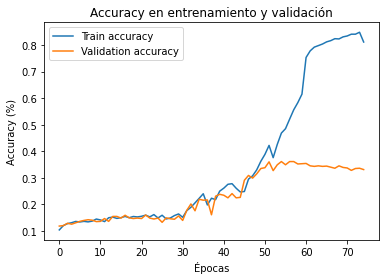

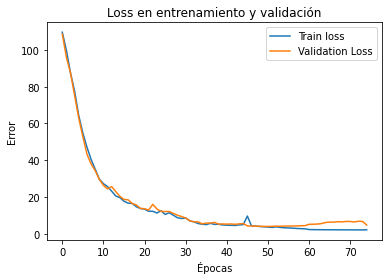

In [ ]:
plt.plot(results[0], label='Train accuracy')
plt.plot(results[2], label='Validation accuracy')
plt.title('Accuracy en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

plt.plot(results[1], label='Train loss')
plt.plot(results[3], label='Validation Loss')
plt.title('Loss en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Error')
plt.legend()
plt.show()

## Probando los resultados

In [ ]:
def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        output = model(X + delta)
        loss = nn.CrossEntropyLoss()(output, y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [ ]:
def plot_results(batch, model, our_model, categories_imagenet):
  images = batch[0]
  labels = batch[1]
  try:
    categories = test_data.classes
  except:
    categories = classes
  plt.figure(figsize=(10, 10))

  model.cpu()
  model.eval()
  our_model.to('cpu')
  our_model.eval()

  imgs = []
  num_images = 9
  
  for i in range(num_images):
    image = images[i].unsqueeze(0).float()
    imgs += [image]

  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    with torch.no_grad():
      output = model(imgs[i])
    _, predicted = torch.max(output.data, 1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title('R: ' + str(categories[labels[i].item()]) + ", P: " + str(categories_imagenet[predicted.item()]))
    plt.axis("off")
  plt.show()

  imgs = []
  for i in range(num_images):
    print(f'image {i}')
    image = images[i].unsqueeze(0).float()  
    label = one_hot_encoding(labels[i], 1000)
    image += pgd_linf(our_model, image, label.unsqueeze(0), epsilon = 0.2, alpha = 0.1, num_iter=20)
    imgs += [image]

  plt.figure(figsize=(10, 10))
  for i in range(num_images):
    ax = plt.subplot(3, 3, i + 1)
    with torch.no_grad():
      output = model(imgs[i])
    _, predicted = torch.max(output.data, 1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title('R: ' + str(categories[labels[i].item()]) + ", P: " + str(categories_imagenet[predicted.item()]))
    plt.axis("off")
  plt.show()

def one_hot_encoding(pos, lenght):
  vector = torch.zeros(lenght)
  vector[pos] = 1
  return vector

In [ ]:
file = open('/content/classes.txt')
categories = []
for line in file:
  categories += [line.replace('\n', '')]
file.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 720x720 with 0 Axes>

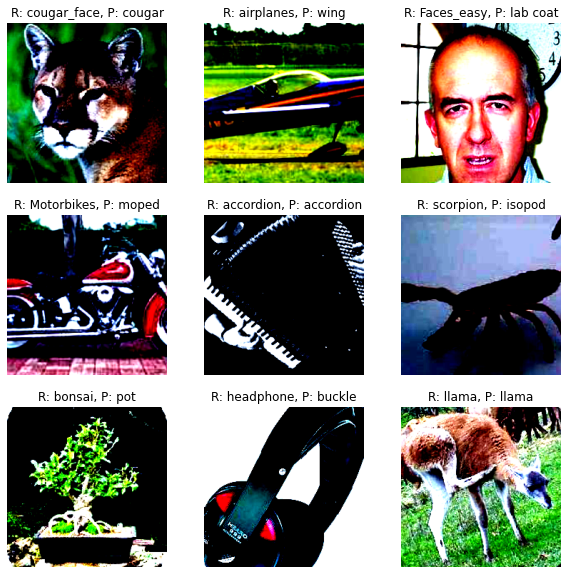

image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


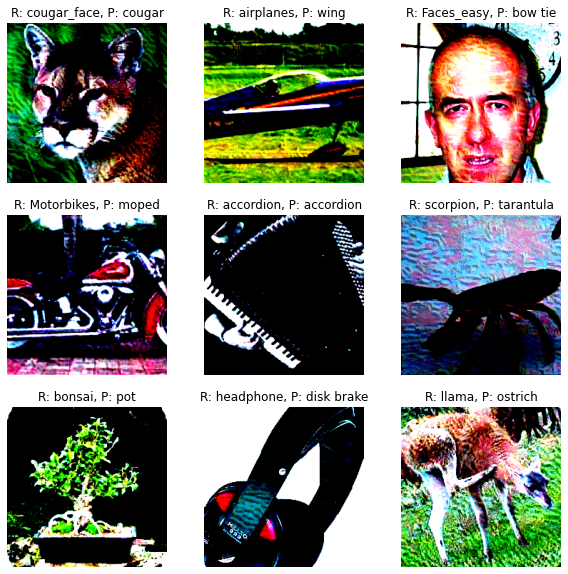

In [ ]:
batch = next(iter(test_data))
plot_results(batch, blackbox, net, categories)

## Un par de resultados más

In [ ]:
total = 0
invariants = 0

blackbox.cuda()
for i, data in enumerate(test_data, 0): # Obtener batch
  inputs = data[0].float().cuda()
  labels = data[1]
  total += len(inputs)

  outputs = blackbox(inputs)
  _, norm_predicted = torch.max(outputs.data, 1)


  for i in range(len(inputs)):
    image = inputs[i]
    label = labels[i].cuda()
    inputs[i] += pgd_linf(net, image.unsqueeze(0), label.unsqueeze(0), epsilon = 0.2, alpha = 0.025, num_iter=8).squeeze(0)
  outputs = blackbox(inputs)
  _, adv_predicted = torch.max(outputs.data, 1)
  
  for i in range(len(norm_predicted)):
    if norm_predicted[i].item() == adv_predicted[i].item():
      invariants += 1



In [ ]:
print(f'Invariantes: {invariants}, Totales: {total}')
print(f' Porcentaje de error: {1 - invariants/total}')

Correctas: 626, Totales: 996
 Porcentaje de error: 0.37148594377510036
